## **Gathering of Data**

In [1]:
import tweepy as tw
import pandas as pd
import numpy as np

import re
import contractions

import nltk
from nltk.corpus import stopwords
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures

from collections import Counter, defaultdict
import spacy

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering

import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors

from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel, AuthorTopicModel
from gensim.corpora import Dictionary
from gensim.models.phrases import Phrases
from gensim.test.utils import datapath, temporary_file

import seaborn as sns

import multiprocessing

nlp = spacy.load('en_core_web_sm')

In [2]:
# Change these 4 to *your* keys

consumer_key = 'htEGOlVlktNK7FuM83plUKYcV'
consumer_secret = 'dyjOLVDtDJyaSLudOtp2VNnSd4iU4gxlg1zMZ5DTSm7nMuWy2x'

access_token = "1359502466941878281-KpjiUIu9HzSJWwRShTQC6SRTKWT5Vw"
access_token_secret = "VwRbLYku2GTjuyvkELufyaIFfZwvff5vGkvCaXqnUKuf3"

# Set up the Authentication for Twitter API
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret) 

# Create the api to connect to twitter with your creadentials
api = tw.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True, compression=True)

In [3]:
search_words = ['@ManUtd', '@ManCity', '@LFC']
ntweets = 30000

I will put under comment the following cells as they were used to get the datasets from twitter and due to legal restrictions, they take some hours

In [4]:
# takes 1 hour and 15 minutes because of the Twitter API legal restrictions

#tweets_df = []
#for i in range (len(search_words)):
#    tweets = tw.Cursor(api.search, q="{} -filter:retweets".format(search_words[i]), lang="en").items(ntweets)
#    tweet_details = [[tweet.text, tweet.user.screen_name] for tweet in tweets]
#    tweet_df = pd.DataFrame(data=tweet_details, columns=["text","user"])
#    tweets_df.append(tweet_df)

In [5]:
#tweets_df[0].to_csv('data/MU_raw.csv', header=True)
#tweets_df[1].to_csv('data/MC_raw.csv', header=True)
#tweets_df[2].to_csv('data/LFC_raw.csv', header=True)

# 1. Data and Preprocessing (5 pts)

Pick a data set with **at least 5,000** documents that you have found yourself.
Briefly (max. 100 words!) describe the content and type of the data set (book, reviews, Twitter, ...). 

Preprocess the data and explain (max. 200 words) which preprocessing steps you chose and why, and give statistics of the number of documents, types, and tokens, before and after preprocessing.

## The project

For this project, I have decided to analyze twitter data to understand the reactions coming from users to three football teams performance (or even external events). In this sense, I have gathered 30,000 tweets for each team by looking for their handles tags. Each tweet will be considered as a document and therefore, we will end with 90,000 documents.
The database in consideration is made of 4 columns: geolocation (if present), text of the tweet, user and location (if present added by the user)

### Reloading of the initial twitter data and cleaning phase

I start by uploading the previously gathered and then saved data. It is saved in three different files, one for each team.

In [6]:
MU_raw = pd.read_csv('data/MU_raw.csv')
MC_raw = pd.read_csv('data/MC_raw.csv')
LFC_raw = pd.read_csv('data/LFC_raw.csv')
tweets_df = [MU_raw, MC_raw, LFC_raw]

In [7]:
def deEmojify(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [8]:
def clean_tweets(text):
    text = contractions.fix(text)
    numbers = re.compile('[0-9]')
    text = re.sub(numbers, '0', text)
    text = re.sub("@[\w]*"," ",text)
    text = re.sub("#[\w]*"," ",text)
    text = re.sub("https?://[A-Za-z0-9./]*"," ",text)
    text = re.sub("\n"," ",text)
    text = deEmojify(text)
    return text

In [9]:
def bigrams_finder (text):
    words = [word.lower() for document in text for word in document.split() 
         if len(word) > 2]
    
    finder = BigramCollocationFinder.from_words(words)
    bgm = BigramAssocMeasures()
    score = bgm.mi_like
    
    collocations = {' '.join(bigram): pmi for bigram, pmi in finder.score_ngrams(score)}
    
    bigram_keys = list(dict(Counter(collocations)))
    bigram_values = list(dict(Counter(collocations)).values())
    bigrams = []
    [bigrams.append(bigram_keys[i].split()) for i in range(len(bigram_keys)) if bigram_values[i]>1]
    
    return bigrams

In [10]:
def preprocessing (text):
    
    stopwords_set = set(stopwords.words('english'))
    bigrams = bigrams_finder(text)
    for i in range (len(text)):
        text[i] = clean_tweets(text[i])
        text[i] = text[i].lower()
        text[i] = " ".join(token.lemma_ for token in nlp(text[i]) 
                           if (token not in stopwords_set
                               and token.pos_ in {'NOUN', 'VERB', 'ADJ', 'ADV', 'X', 'PROPN'}))
        #text[i] = text[i].replace("mancity", ' ')
        #text[i] = text[i].replace("manutd", ' ')
        #text[i] = text[i].replace("liverpool", ' ')
        #for w1,w2 in bigrams:
         #   if ("%s %s" % (w1,w2)) in text[i]:
          #       text[i] = text[i].replace("%s %s" % (w1, w2), "%s_%s" % (w1, w2))
           # else:
            #     text[i] = text[i]
        text[i] = re.sub(r'\b\w{1,3}\b', ' ', text[i])
        
    return text

In [11]:
# Run only if necessary as this code takes some time (on my MacBook Pro M1 took 8 minutes).
# You can easily access the processed data from the following csv files (team_clean.csv)
MU_clean = preprocessing(MU_raw['text'].copy())
MC_clean = preprocessing(MC_raw['text'].copy())
LFC_clean = preprocessing(LFC_raw['text'].copy())

In [12]:
MU_clean.to_csv('data/MU_clean.csv', header=True)
MC_clean.to_csv('data/MC_clean.csv', header=True)
LFC_clean.to_csv('data/LFC_clean.csv', header=True)

### Preprocessing 
I start the preprocessing phase with 90,000 documents. The main steps that I take to clean the dataset are divided into two phases:
1. Clean twitter extra data:
      1. Fix contracted words
      2. Substitute numbers with 0
      3. Remove tags, hashtags and weblinks
      4. Remove all the emoticons

2. Preprocess data:
      1. Put all documents in lowercase
      2. Lemmatize and remove all the English stopwords (I chose to lemmatize and 
      3. Remove words with lenght lower than 3 (this step is important as we can yet encounter two to three letters meaningless words)
      
At the end of this phase, I still have ***89,356*** clean documents


### Preprocessed data

In [13]:
MU_clean = pd.read_csv('data/MU_clean.csv')
MC_clean = pd.read_csv('data/MC_clean.csv')
LFC_clean = pd.read_csv('data/LFC_clean.csv')

In [14]:
MU_clean = MU_clean.dropna()
MC_clean = MC_clean.dropna()
LFC_clean = LFC_clean.dropna()
tweets_clean = [MU_clean, MC_clean, LFC_clean]

In [15]:
full_tweets = pd.concat([MU_clean, MC_clean, LFC_clean]).reset_index(drop=True)

## The analysis 

The main objective of this analysis is to study the different behaviour of Premier League teams' fans reactions to both their performance and external events. I will be presenting all the analysis with the complete datasets and leave the comparison between the three different teams to the last visualization segment of the assignment.

I will start with a **TF-IDF** analysis to detect some of the most important words in entire corpus. Then, I will move on with the two embedding analysis, **Word2Vec** and **Doc2Vec**, to find similar words to the ones with highest scores in the TF-IDF. Next, I will move on to analyse the topics through the **Topic model** (both with **LDA** and **Author**) and check whether it is possible to reduce dimensions through **Dimensionality Reduction techniques** (both with **latent topics** and **k-means**). Finally, I will implement a language model to try and generate some text, starting from some initial words.

## TF-IDF

The first analysis that I have decided to carry out is the Term Frequency - Inverse Document Frequency (TF-IDF) analysis. This will allow me to find the most important words in the whole document set. 

In [16]:
def TFIDF (df):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), 
                                   stop_words='english', 
                                   analyzer='word', 
                                   min_df=0.01, 
                                   max_df=0.7, 
                                   sublinear_tf=True, 
                                   use_idf=True)
    
    count_vectorizer = CountVectorizer(ngram_range=(1,2), 
                                   stop_words='english', 
                                   analyzer='word', 
                                   min_df=0.01, 
                                   max_df=0.7)
    
    X = tfidf_vectorizer.fit_transform(df.text)
    X_word = count_vectorizer.fit_transform(df.text)

    word_counts = X_word.toarray()
    word_tfidf = X.toarray()
    
    df_tfidf = pd.DataFrame(data = {'word': count_vectorizer.get_feature_names(),
                                'tf': word_counts.sum(axis = 0),
                                'idf': tfidf_vectorizer.idf_,
                                'tfidf': word_tfidf.sum(axis=0)})

    df_tfidf = df_tfidf.sort_values(['tfidf','tf','idf'], ascending=False)
    
    #Graph

    fig, ax = plt.subplots(figsize = (16,9))

    plt.scatter(x = df_tfidf.tfidf,
                 y = df_tfidf.idf, 
                 s = df_tfidf.tf,
                 c = 'g',
                 alpha = 0.5,
                 edgecolors='g', 
                 label=df_tfidf.word)
    
    plt.xlabel('tfidf')
    plt.ylabel('idf')

    return df_tfidf

In [17]:
index = []
for i in range (len(full_tweets)):
    if i < len(MU_clean):
        index.append('MU')
    elif i < len(MU_clean + MC_clean):
        index.append('MC')
    else:
        index.append('LFC')

teams_tweets = pd.DataFrame({'Team':index, 'text':full_tweets.text})
teams_tweets

,Team,text
0,MU,wife huge where whole family jersey ha...
1,MU,favorite player lock screen martial
2,MU,still strongly affirm would good signing cou...
3,MU,should sell lingard mata keep lingrad
4,MU,fifa
...,...,...
89351,LFC,liverpool manchester united same point last ma...
89352,LFC,leadership pure simple learn include polit...
89353,LFC,klopp offer positive outlook keita liverpool c...
89354,LFC,viral know where stand jurgen klopp po...


,word,tf,idf,tfidf
12,come,5338,3.851509,3331.846452
21,game,7049,3.642611,3267.502709
23,good,5882,3.798861,3007.732857
67,team,5863,3.818538,2823.787736
32,just,4942,3.946781,2684.933891
52,play,5307,3.918829,2595.514402
22,goal,4941,4.041026,2528.164433
73,today,4331,4.070978,2416.081292
9,city,5030,3.979933,2382.149615
71,time,4272,4.100115,2279.098795


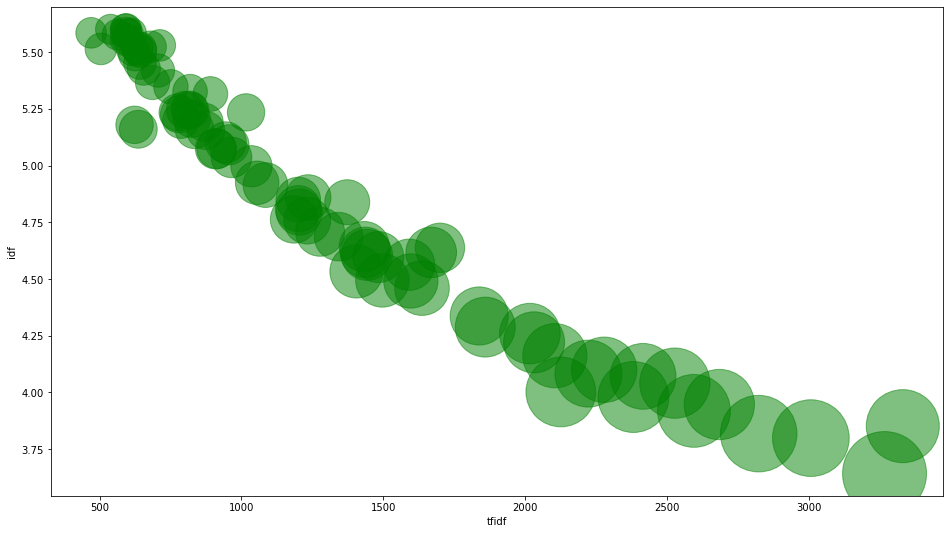

In [18]:
full_tfidf = TFIDF(teams_tweets)
full_tfidf.head(20)

The above scatterplot represents the TF-IDF of the dataset containing all the preprocessed documents. We can clearly see that the most important words are:
* come with *TF-IDF* = 3331
* game with *TF-IDF* = 3267
* good with *TF-IDF* = 3007
* team with *TF-IDF* = 2823
* just with *TF-IDF* = 2684
* play with *TF-IDF* = 2595
* goal with *TF-IDF* = 2528
All of the above seem to be reasonable as they are in some way related to football. Moreover, even the ones that come a bit lower in the sorted dataframe are very much important for the topic

## Word2vec 

Next, I am going to implement the Word2Vec analysis to find the most similar words to ***good*** (which was one of the most important words in the previous analysis).

In [19]:
def word2vec (tweets):
    corpus = [document.split() for document in tweets.text]
    
    models = []
    
    nmodels = 5
    
    for i in range (nmodels):
        w2v_model = Word2Vec(size=300,
                         sample = 0.000001,      # subsampling rate
                         window = 5, #semantic or syntactic similarity
                         iter = 500,                 # iterations
                         negative = 5,               # negative samples
                         min_count = 10,             # minimum threshold
                         workers = -1               # parallelize to all cores
        )

        w2v_model.build_vocab(corpus)
        w2v_model.train(corpus, 
                        total_examples=w2v_model.corpus_count, 
                        epochs=w2v_model.epochs)
        models.append(w2v_model)
    
    voc = models[4].wv.vocab
    for word in voc:
        means = []
        for i in zip(models[0][word], models[1][word], models[2][word], models[3][word], models[4][word]):
            means.append(np.mean(i))
        models[4].wv.syn0[w2v_model.wv.vocab[word].index] = np.array(means)
            
    return models[4]

In [20]:
def closestwords_tsnescatterplot(model, word, title):
    colors = sns.color_palette("CMRmap", 3)
    i = 0
    
    arr = np.empty((0,300), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.most_similar(word)

    # add the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)

    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, init='pca', n_iter=4000, random_state=42)
    np.set_printoptions(suppress=True)

    Y = tsne.fit_transform(arr)
    
    x = []
    y = []
    
    for value in Y:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(10, 7)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i], color = 'g')
        plt.annotate(word_labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.title(title)
    plt.show()

In [21]:
w2v_model = word2vec(teams_tweets)

<ipython-input-19-bc9a9bc55217>:27: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  for i in zip(models[0][word], models[1][word], models[2][word], models[3][word], models[4][word]):
<ipython-input-19-bc9a9bc55217>:29: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  models[4].wv.syn0[w2v_model.wv.vocab[word].index] = np.array(means)


In [22]:
w2v_model.most_similar('good')

<ipython-input-22-7010a9ce9198>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  w2v_model.most_similar('good')


[('quote', 0.18061566352844238),
 ('uganda', 0.17653118073940277),
 ('postpone', 0.17583610117435455),
 ('rhys', 0.17563295364379883),
 ('over', 0.17385756969451904),
 ('selhurst', 0.16837257146835327),
 ('disrespect', 0.1609717309474945),
 ('laporte', 0.15938851237297058),
 ('await', 0.15927371382713318),
 ('train', 0.15775418281555176)]

<ipython-input-20-ea512a8b9f2b>:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  close_words = model.most_similar(word)
<ipython-input-20-ea512a8b9f2b>:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  wrd_vector = model[wrd_score[0]]


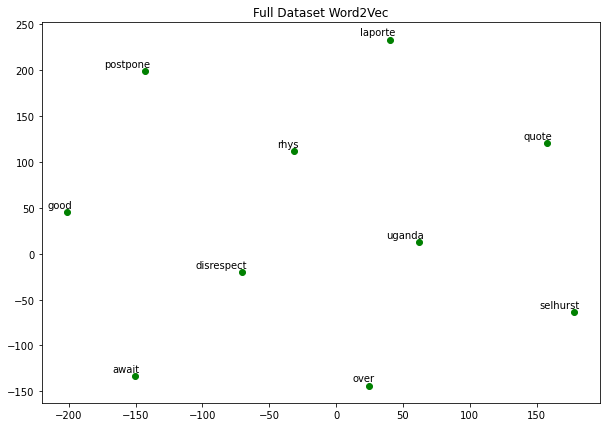

In [23]:
closestwords_tsnescatterplot(w2v_model, 'good', 'Full Dataset Word2Vec')

As Word2Vec is a stochastic process, I have decided to run 4 different models and then do their average to get a more precise model. As I am using the entire corpus, I find the closest words to the given key with a full model. For completeness, I have reported both the list of the most similar words and the scatter plot to visually see th resuls. I will take a deeper look into this topic in third segment by training the model on the three single datasets and on the three most important words that we have got from the previous model.

## Doc2vec

After having analyzed the dataset by the semantic distribution of words, I would like to move to the analysis of the feature representations by document.

In [24]:
def doc2vec (tweets):    
    # create a list of TaggedDocument objects
    corpus = []

    for label, text in zip(tweets.Team, tweets.text):
        corpus.append(TaggedDocument(words=text.split(), 
                                     tags=[str(label)]))

    print('done')
    # initialize model
    d2v_model = Doc2Vec(vector_size=300, 
                        window=15,
                        hs=0,
                        sample=0.00001,
                        negative=3,
                        min_count=3,
                        workers=-1,
                        epochs=500,
                        dm=0, 
                        dbow_words=1)

    # build the vocabulary
    d2v_model.build_vocab(corpus)

    # train the model
    d2v_model.train(corpus, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)
    
    return d2v_model

In [25]:
d2v_model = doc2vec(teams_tweets)

done


In [26]:
d2v_model.most_similar('good')

<ipython-input-26-d2af133bf8dd>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  d2v_model.most_similar('good')


[('quote', 0.18061567842960358),
 ('rösler', 0.17964988946914673),
 ('criminally', 0.17964300513267517),
 ('pinnacle', 0.1782940775156021),
 ('roster', 0.17782486975193024),
 ('seize', 0.17671114206314087),
 ('uganda', 0.17653118073940277),
 ('postpone', 0.17583610117435455),
 ('thurbin', 0.17578232288360596),
 ('rhys', 0.17563295364379883)]

<ipython-input-20-ea512a8b9f2b>:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  close_words = model.most_similar(word)


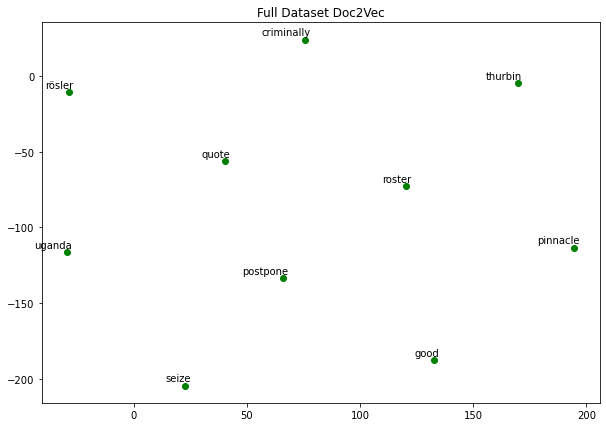

In [27]:
closestwords_tsnescatterplot(d2v_model, 'good', 'Full Dataset Doc2Vec')

Similarly to before, also here we can see the most similar words to the key ***good***. Instantly, we can notice that the distribution has changed almost completely from the earlier results. This is because, we are not considering any more the semantic distribution word, but entire documents.

## TOPIC MODELS

Topic models are able to identify the topics that the documents talk about. In order to do this, we first find how many topics are there and then run the model with the right number of topics to get the ideal model. In particular, I am going to find the right number of topics with both the methods we have covered during the lectures: **LDA** and **Author**. For each proposed method we will find the ideal number of topics and then derive the most precise model.

In [28]:
def find_Lda_model (model_corpus, dictionary):
    coherence_values = []

    for num_topics in range(1, 20):
        model = LdaMulticore(corpus = model_corpus, 
                             id2word = dictionary, 
                             num_topics = num_topics, 
                             random_state = 42)

        coherencemodel_umass = CoherenceModel(model = model, 
                                              texts = instances, 
                                              dictionary = dictionary, 
                                              coherence = 'u_mass')

        coherencemodel_cv = CoherenceModel(model = model, 
                                           texts = instances, 
                                           dictionary = dictionary, 
                                           coherence = 'c_v')

        umass_score = coherencemodel_umass.get_coherence()
        cv_score = coherencemodel_cv.get_coherence()

        print(num_topics, umass_score, cv_score)
        coherence_values.append((num_topics, umass_score, cv_score))
        
    score_graphs (coherence_values)

In [34]:
def best_Lda_model (model_corpus, num_topics):
    
    num_passes = 10
    chunk_size = len(model_corpus) * num_passes/200
    print(chunk_size)

    model = LdaMulticore(num_topics=num_topics, # number of topics
                         corpus=model_corpus, # what to train on 
                         id2word=dictionary, # mapping from IDs to words
                         workers=min(10, multiprocessing.cpu_count()-1), # choose 10 cores, or whatever computer has
                         passes=num_passes, # make this many passes over data
                         chunksize=chunk_size, # update after this many instances
                         alpha=0.5,
                         random_state=42
                        )
    
    topic_corpus = model[model_corpus]

    #Now we clean up the data and find the descriptors
    topic_sep = re.compile("0\.[0-9]{3}\*") 
    model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) 
                    for topic_no, model_topic in
                    model.print_topics(num_topics=num_topics, num_words=5)]

    descriptors = []
    for i, m in model_topics:
        descriptors.append(", ".join(m[:2]).replace('"', ''))
    
    target_category = 'Team'
    scores = [[t[1] for t in topic_corpus[entry]] for entry in range(len(topic_corpus))]

    topic_distros = pd.DataFrame(data=scores, columns=descriptors)
    topic_distros['category'] = teams_tweets[target_category]
    
    # PLOT
    fig, ax = plt.subplots(figsize=(20, 10)) # set graph size

    aggregate_by_category = topic_distros[topic_distros.category.isin('MU MC LFC'.split())]
    aggregate_by_category = aggregate_by_category.groupby(aggregate_by_category.category).mean()

    aggregate_by_category[descriptors].plot.bar(ax=ax);

    # move the legend out
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

In [30]:
def score_graphs (coherence_values):
    scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])
    # scores['UMass'] = -scores['UMass']
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(1,20));
    scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(1,20));

In [31]:
instances = teams_tweets.text.apply(str.split).tolist()
phrases = Phrases(instances, min_count=5, threshold=1)
instances_colloc = phrases[instances]

dictionary = Dictionary(instances_colloc)
dictionary.filter_extremes(no_below=100, no_above=0.5)


ldacorpus = [dictionary.doc2bow(text) for text in instances]

tfidfmodel = TfidfModel(ldacorpus)

model_corpus = tfidfmodel[ldacorpus]

1 -3.034444539151855 0.1143611670696348
2 -3.1551461853450937 0.158785171530747
3 -3.583324691621204 0.2439664181457987
4 -3.6832160618247265 0.23431701726412119
5 -3.7027074210446607 0.24673911731090697
6 -3.709439874627451 0.24339673430249079
7 -3.87138769791735 0.24801075970154035
8 -3.9038079534048693 0.253853798328709
9 -3.6785734174734546 0.25801866681674795
10 -3.8725339365283267 0.2696359866660524
11 -3.8459943171451383 0.2623999574721161
12 -4.0267335636400245 0.26884271480302924
13 -3.8632314169569257 0.2680548820898901
14 -3.950075667060376 0.2919508489281849
15 -3.8931243557520596 0.2748564326140895
16 -4.171553219726693 0.2838003018638817
17 -3.831684252276481 0.2825491338882098
18 -4.285949847649489 0.27843137014168234
19 -4.336833603227924 0.2920355974948062


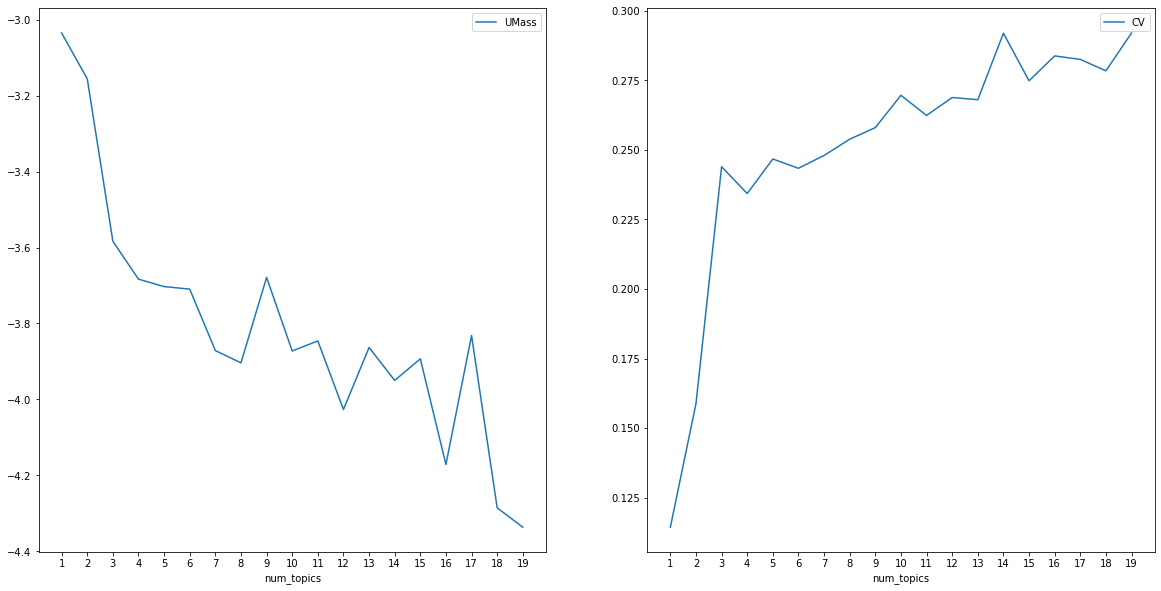

In [32]:
find_Lda_model (model_corpus, dictionary)

4467.8


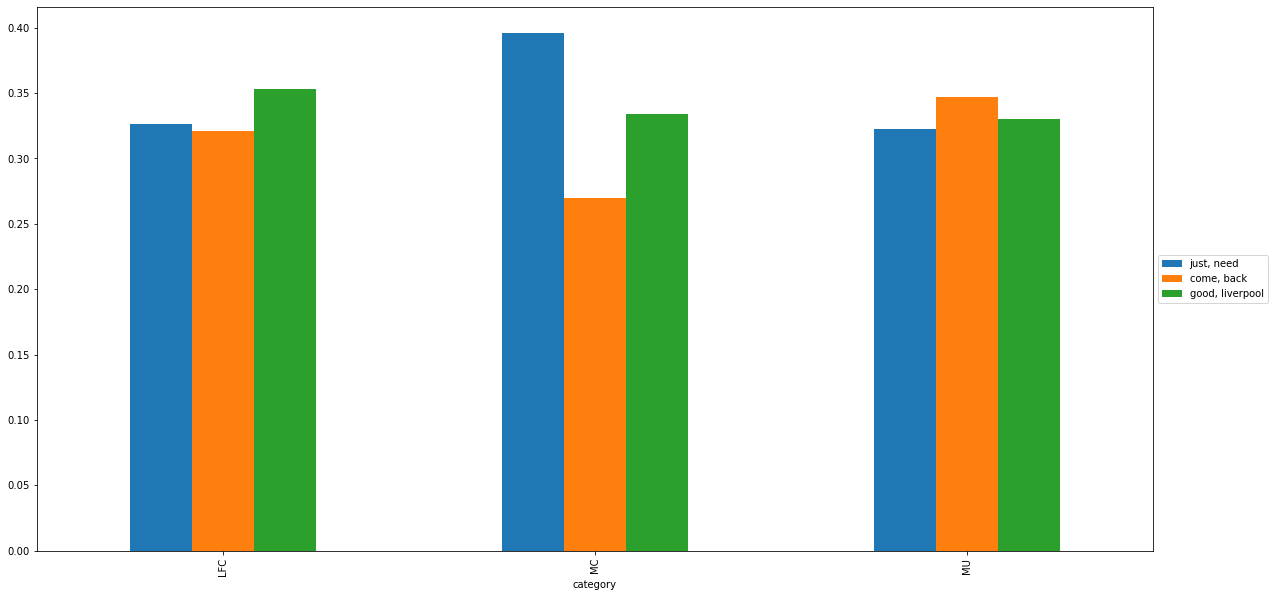

In [35]:
num_topics = 3
best_Lda_model (model_corpus, num_topics)

In [36]:
author2doc = defaultdict(list) # mapping from country to document

for i, team in enumerate(teams_tweets['Team']):
    author2doc[team].append(i)

instances = teams_tweets.text.apply(str.split).tolist()
phrases = Phrases(instances, min_count=5, threshold=1)
instances_colloc = phrases[instances]

dictionary = Dictionary(instances_colloc)
dictionary.filter_extremes(no_below=100, no_above=0.5)

ldacorpus = [dictionary.doc2bow(text) for text in instances]

tfidfmodel = TfidfModel(ldacorpus)

model_corpus = tfidfmodel[ldacorpus] 

In [37]:
def find_author_model (model_corpus, dictionary, author2doc):
    coherence_values = []
    author_model_list = []

    dev_size = 15000

    dev_author2doc = {key: [idx for idx in value if idx < dev_size] for key, value in author2doc.items()}

    for num_topics in range(1, 20):
        author_model = AuthorTopicModel(corpus=list(model_corpus[:dev_size]), 
                                        author2doc=dev_author2doc, # the only difference to LDA 
                                        id2word=dictionary, 
                                        num_topics=num_topics,
                                        alpha=0.5,
                                        random_state=42
                                       )

        coherencemodel_umass = CoherenceModel(model=author_model, 
                                              texts=instances[:dev_size], 
                                              dictionary=dictionary, 
                                              coherence='u_mass')

        coherencemodel_cv = CoherenceModel(model=author_model, 
                                           texts=instances[:dev_size], 
                                           dictionary=dictionary, 
                                           coherence='c_v')

        umass_score = coherencemodel_umass.get_coherence()
        cv_score = coherencemodel_cv.get_coherence()

        print(num_topics, umass_score, cv_score)
        coherence_values.append((num_topics, umass_score, cv_score))

    scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])
    
    %matplotlib inline
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(1,20));
    scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(1,20));

In [38]:
def best_author_model (model_corpus, dictionary, author2doc, n_topics_author):
    
    chunk_size = len(model_corpus) * 5/200
    
    author_model = AuthorTopicModel(corpus=list(ldacorpus), 
                                    author2doc=author2doc, 
                                    id2word=dictionary, 
                                    num_topics=n_topics_author,
                                    passes=5,
                                    chunksize=chunk_size,
                                    alpha=0.5,
                                    random_state=42
    )
    topic_sep = re.compile("0\.[0-9]{3}\*")
    author_model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                author_model.print_topics(num_topics=n_topics_author, num_words=5)]

    author_descriptors = []
    for i, m in sorted(author_model_topics):
        author_descriptors.append(", ".join(m[:2]).replace('"', ''))
        
    author_vecs = {author: {author_descriptors[t]: 0.0
                             for t in range(author_model.num_topics)}
                  for author in author_model.id2author.values()
                  }

    for author in author_model.id2author.values():
        for (t, v) in author_model.get_author_topics(author):
            author_vecs[author][author_descriptors[t]] = v


    target_teams = 'MU MC LFC'.split()
            
    author_df = pd.DataFrame.from_dict(author_vecs)

    fig, ax = plt.subplots(figsize=(20,10))
    author_df[target_teams].T.plot.bar(ax=ax)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

1 -4.914798048999309 0.3403876863607411
2 -5.295220278130358 0.2753361082473008
3 -6.869317562090195 0.3396689318479953
4 -7.839977834031076 0.36409862435270324
5 -8.51165976754269 0.4023804664683538
6 -9.75362207452612 0.4087172939887276
7 -10.762685382511133 0.4358533045020127
8 -11.090969176140248 0.4322679247903114
9 -10.821872907704266 0.4349077891053479
10 -11.020453922472539 0.4343215827659357
11 -11.734750473238943 0.45207118835579646
12 -11.584581637556028 0.4422643773761365
13 -12.082193597662329 0.4625624038489782
14 -12.141411774312504 0.46702475786252695
15 -11.783682298118949 0.45191692575522835
16 -12.217381680890535 0.46359635876671007
17 -12.189879448106899 0.4615380565299375
18 -12.336617606396755 0.4607813560880614
19 -12.67323680754745 0.47330010621741314


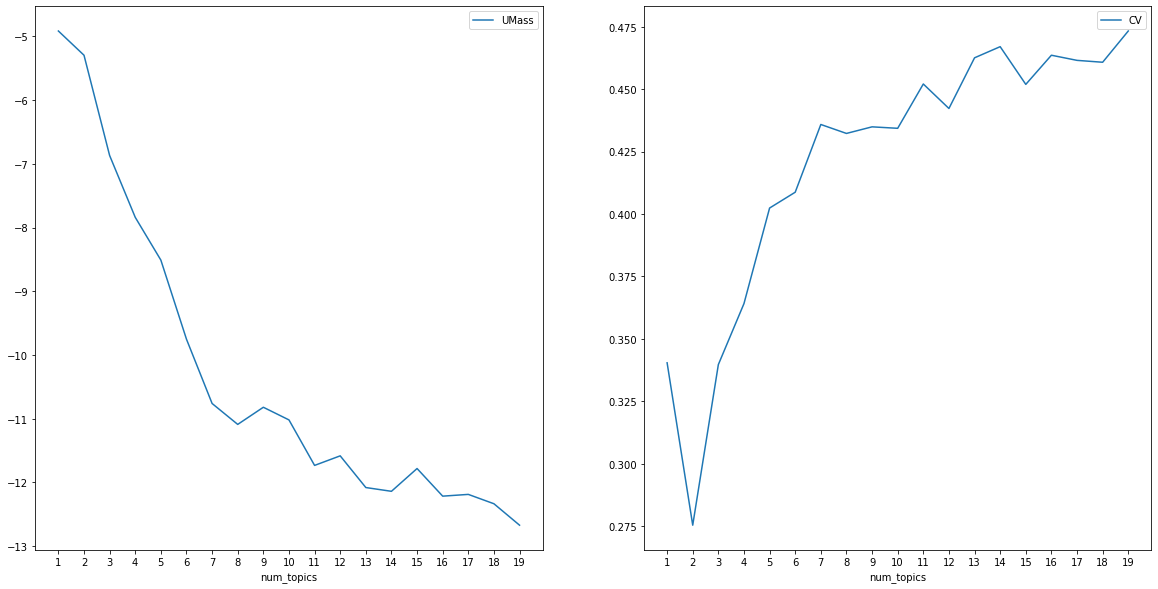

In [39]:
find_author_model (model_corpus, dictionary, author2doc)

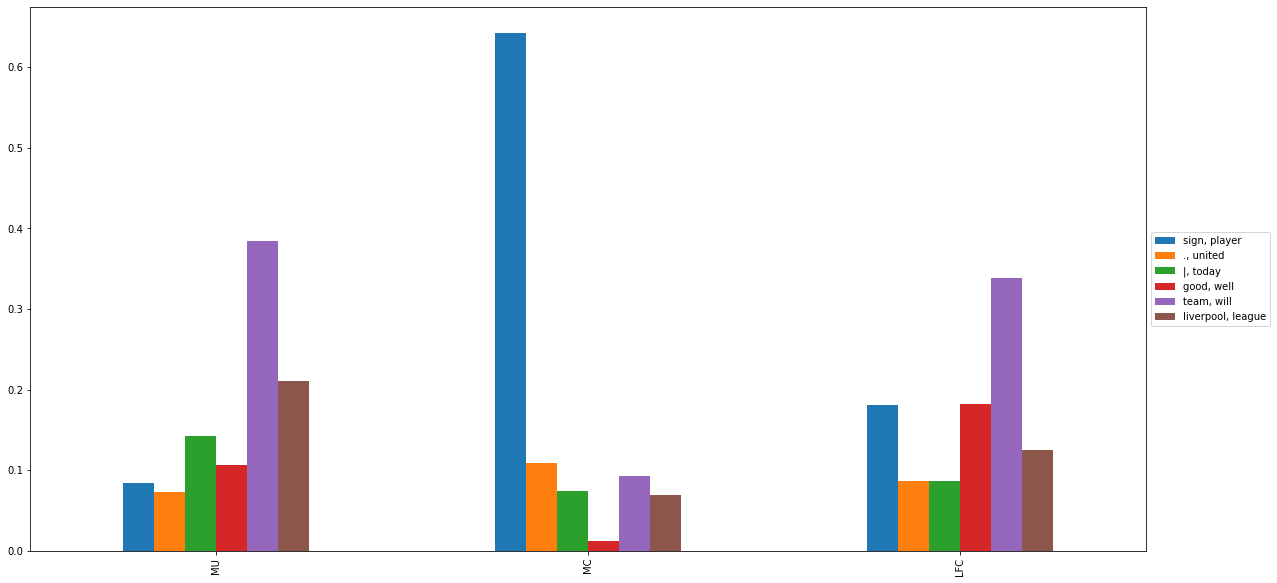

In [41]:
num_topics = 6
best_author_model (model_corpus, dictionary, author2doc, num_topics)

In both the models proposed above, I have looked for the best number of topics in the corpus by finding their CV and UMass scores. The objective was to maximize both, however, due to the nature of the score and due to nature of the data, It was not possible. To tackle this issue, I had to take choose a value that had decent scores in both these score metrics and therefore made the best guess.

# Dimensionality reduction 

In this analysis, I want to reduce the dimensions of my dataset to make it easier to work with. We have discussed two main approaches: **latent dimension** and **clustering**. Furthermore, in the first approach, we have gone through two methods: **SVD** and **NMF**.

In this block I am going to analyse latent dimensions throughthe SVD approach and clustering.

In [42]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), 
                                   stop_words='english', 
                                   analyzer='word', 
                                   min_df=0.0001, 
                                   max_df=0.75, 
                                   sublinear_tf=True, 
                                   use_idf=True)

X = tfidf_vectorizer.fit_transform(teams_tweets.text)

In [43]:
#SVD

k = 5  # number of latent components

svd = TruncatedSVD(n_components=k)
U = svd.fit_transform(X)
S = svd.singular_values_
V = svd.components_

### Latent topics 

In [44]:
sns.set_context('notebook')

def plot_vectors(vectors, title='VIZ', labels=None, dimensions=3):

    # set up graph
    fig = plt.figure(figsize=(12,12))

    # create data frame
    df = pd.DataFrame(data={'x':vectors[:,0], 'y': vectors[:,1]})
    # add labels, if supplied
    if labels is not None:
        df['label'] = labels
    else:
        df['label'] = [''] * len(df)

    cm = plt.get_cmap('winter')
    n_labels = len(df.label.unique())
    label_colors = [cm(1. * i/n_labels) for i in range(n_labels)]
    cMap = colors.ListedColormap(label_colors)    
    df['z'] = vectors[:,2]

    ax = fig.add_subplot(111, projection='3d')
    frame1 = plt.gca() 


    # plot each label as scatter plot in its own color
    for l, label in enumerate(df.label.unique()):
        df2 = df[df.label == label]
        color_values = [label_colors[l]] * len(df2)
        ax.scatter(df2['x'], df2['y'], df2['z'],
                   c=color_values, 
                   cmap=cMap, 
                   label=label, 
                   alpha=0.4, 
                   s=100)

    plt.title(title)
#     plt.legend()
    plt.show()

In [45]:
def show_topics(A, vocabulary, topn=5):

    topic_words = ([[vocabulary[i] for i in np.argsort(t)[:-topn-1:-1]]
                    for t in A])
    return [', '.join(t) for t in topic_words]

terms = tfidf_vectorizer.get_feature_names()

In [46]:
low_dim_svd = TruncatedSVD(n_components=3)

Z = X[:100]
categories = teams_tweets.text[:100]

low_dim_U = low_dim_svd.fit_transform(Z)

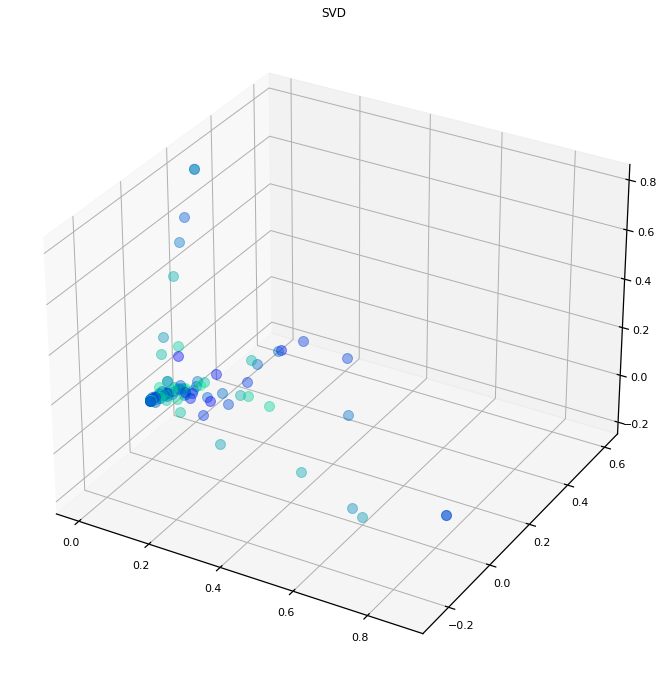

In [47]:
plot_vectors(low_dim_U, title='SVD', labels=categories)

### Clustering 

In [48]:
def clustering (X, k):
    X2 = TruncatedSVD(n_components=400).fit_transform(X)
    agg = AgglomerativeClustering(n_clusters=k)
    sample = np.random.choice(len(X2), replace=False, size=8000)
    agg_sample_ids = agg.fit_predict(X2[sample])
    centroids = np.array([X2[sample][agg_sample_ids == c].mean(axis=0) for c in range(k)])
    km = KMeans(n_clusters=k, n_jobs=-1, init=centroids)
    km.fit(X2)
    plot_sample = np.random.choice(len(X2), replace=False, size=200)
    plot_vectors(X2[plot_sample], labels=km.labels_[plot_sample])

/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


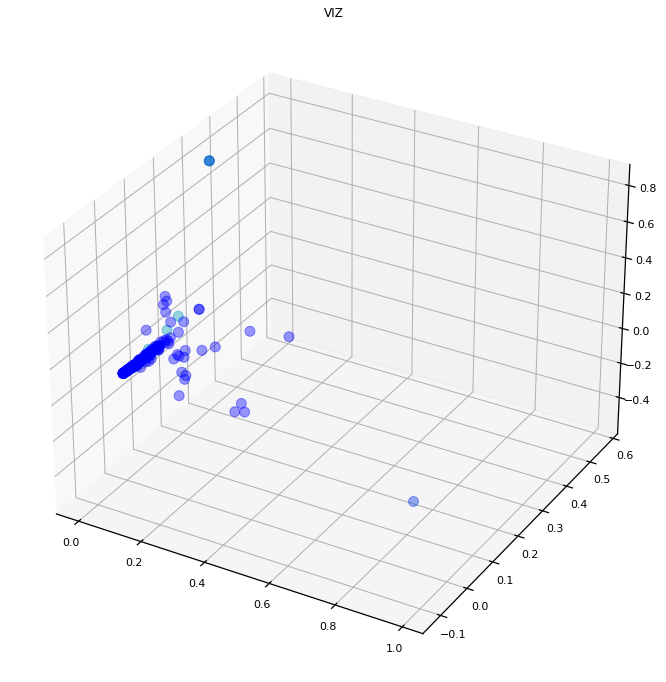

In [49]:
k = 5

clustering(X, k)

For what regards clustering with k-means, it is necessary to provide the ideal number of clusters to the algorithm. In order to find it we calculate the silhouette score to find the optimal k. We will look for the parameter for which we have the highest score.

/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


5 0.17499772554092227


/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


6 0.10983876188461313


/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


7 0.17757499449870748


/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


8 0.1719831236970777


/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


9 0.16447762660830975


/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


10 0.08700275078156952


/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


11 0.10150981496133131


/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


12 0.11186777156251565


/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


13 0.10233065869467105


/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


14 0.11109442326178755


/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


15 0.09671965261412713


/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


16 0.12174652443574896


/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


17 0.10296275275384857


/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


18 0.10693047316099803


/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


19 0.07639112483278811


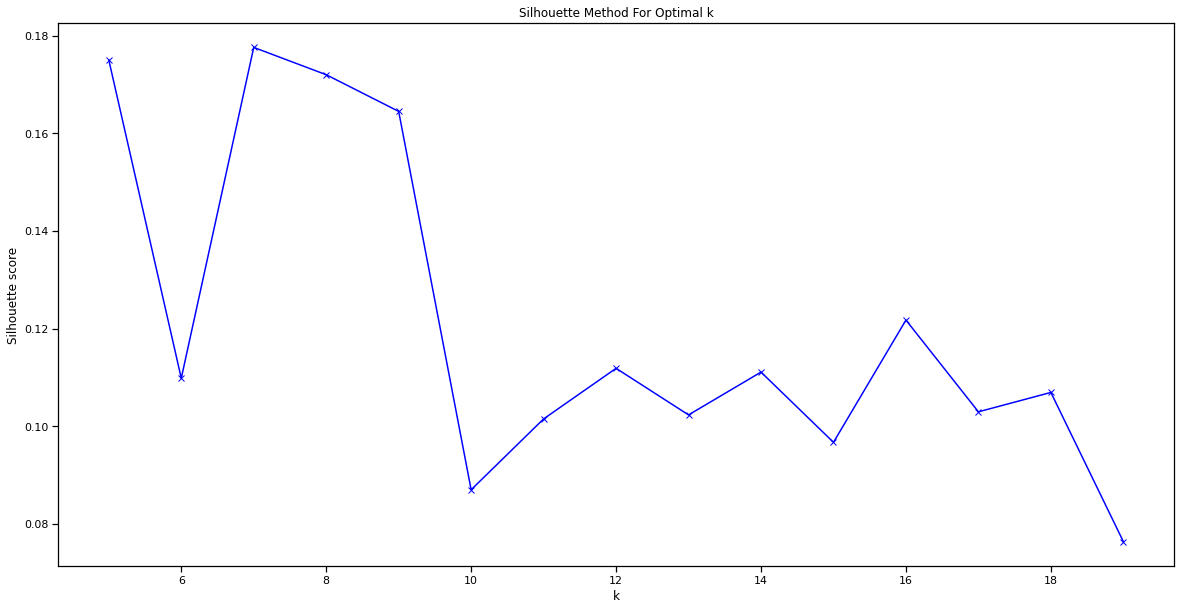

In [50]:
silhouettes = []

K = range(5, 20)

for c in K:
    agg_clustering = AgglomerativeClustering(n_clusters=c)
    X2 = TruncatedSVD(n_components=300).fit_transform(X)
    sample = np.random.choice(len(X2), replace=False, size=10000)

    agg_cluster_ids = agg_clustering.fit_predict(X2[sample])
    agg_centroids = np.array([X2[[i for i, v in enumerate(agg_cluster_ids) if v == k]].mean(axis=0) 
                            for k in range(c)])

    kmeans_clustering = KMeans(n_clusters=c, n_jobs=-1, init=agg_centroids)
    kmeans_ids = kmeans_clustering.fit_predict(X2)
    score = silhouette_score(X2[sample], agg_cluster_ids)
    silhouettes.append(score)
    print(c, score)
    
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method For Optimal k')
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


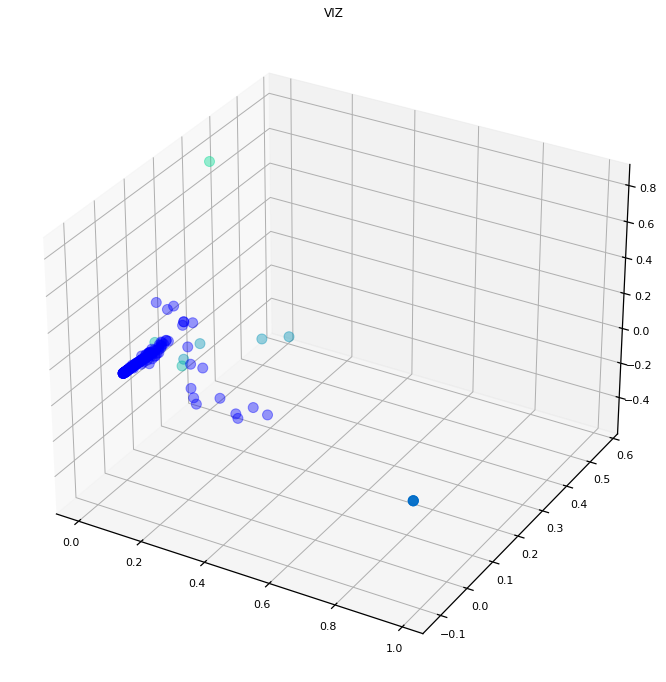

In [62]:
k = 7

clustering(X, k)

# Language Models 

Finally, I have decided to go create a generative language model to implement our knowlengde of n-grams into the analysis. In particular, I have developed a generative model which creates, mostly senseless, sentences given some initial words.

In [53]:
def generate(initial=[]):
    smoothing = 0.001
    START = '_***_'
    STOP = '_STOP_'

    # map from (u, v) to w = (w|u,v)
    counts = defaultdict(lambda: defaultdict(lambda: smoothing))

    # fit data on corpus
    corpus = [document.split() for document in teams_tweets.text]
    # collect counts for MLE
    for sentence in corpus:
        # include special tokens for start and the end of sentence
        tokens = [START, START] + sentence + [STOP]
        for u, v, w in nltk.ngrams(tokens, 3):
            counts[(u, v)][w] += 1
    
    result = [START, START] + initial
    for i in range(len(result)-1):
        try:
            next_word = sample_next_word(result[-(i+2)], result[-(i+1)])
        except ValueError:
            pass
    result.append(next_word)
    while next_word != STOP:
        try:
            next_word = sample_next_word(result[-2], result[-1])
        except ValueError:
            next_word = sample_next_word(START, result[-1])
        result.append(next_word)
    return ' '.join(result[2:-1])

def sample_next_word(u, v):
    """
    sample a word w based on the history (u, v)
    """
    # separate word and their counts into separate variables
    keys, values = zip(*counts[(u, v)].items())

    # normalize the counts into a probability distribution
    values = np.array(values)
    values /= values.sum() # create probability distro
    
    # this is the meat of the function
    sample = np.random.multinomial(1, values) # pick one position

    return keys[np.argmax(sample)]

In [64]:
print(generate('Natural Language Processing is'.split()))

Natural Language Processing is long journey home


# Visualizations

In this segment, I am going to present all the graphs that I have used during the analysis above for the separate datasets. Moreover, I will implement them with also other graphical visualizations.

### TF-IDF

The next three graphs will show the TF-IDF analysis for each team and will highlight the most important words in their respective TF-IDF dataframes.

,word,tf,idf,tfidf
10,come,1919,3.766863,1203.338772
39,manchester,2054,3.743631,1146.085526
20,good,2141,3.696234,1088.370141
18,game,2317,3.648605,1080.425119
73,united,2079,3.744153,964.840554
70,today,1609,3.965340,901.335629
48,play,1839,3.878057,894.885535
65,team,1826,3.888862,870.178124
29,just,1588,3.987739,841.557267
66,thank,1094,4.335602,781.979642


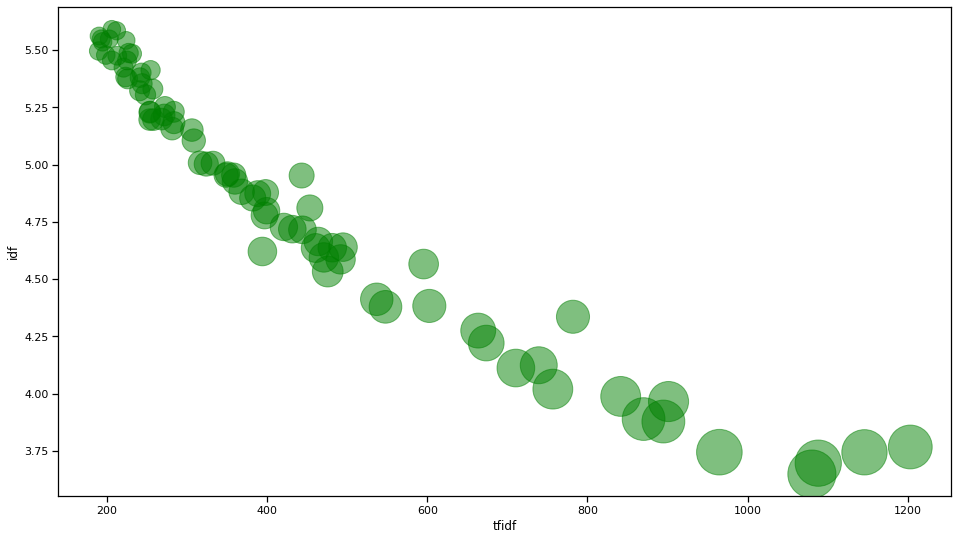

In [55]:
MU_tfidf = TFIDF(MU_clean)
MU_tfidf.head(20)

,word,tf,idf,tfidf
8,city,3587,3.240703,1508.220515
23,game,2595,3.552091,1144.338445
12,come,1793,3.844950,1099.027182
70,team,2093,3.753000,990.470861
25,good,1872,3.861229,961.486737
24,goal,1797,3.909257,952.804806
37,league,2130,3.701733,924.342941
76,today,1508,4.026579,834.335766
35,just,1455,4.063203,774.421881
54,play,1576,4.048958,756.916280


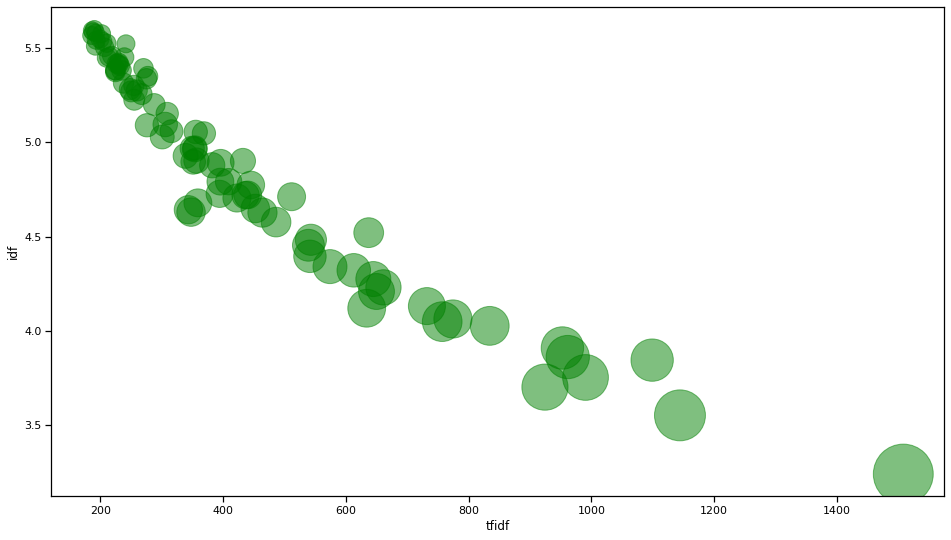

In [56]:
MC_tfidf = TFIDF(MC_clean)
MC_tfidf.head(20)

,word,tf,idf,tfidf
48,liverpool,2849,3.419847,1341.618169
42,just,1899,3.805665,1027.006742
14,come,1626,3.950135,1008.515319
27,game,2137,3.734858,949.579693
29,good,1869,3.846511,922.720193
77,team,1944,3.817407,902.000133
62,play,1892,3.840161,877.696300
72,season,1783,3.923518,843.868410
28,goal,1926,3.974186,842.306218
81,time,1627,3.963715,818.552277


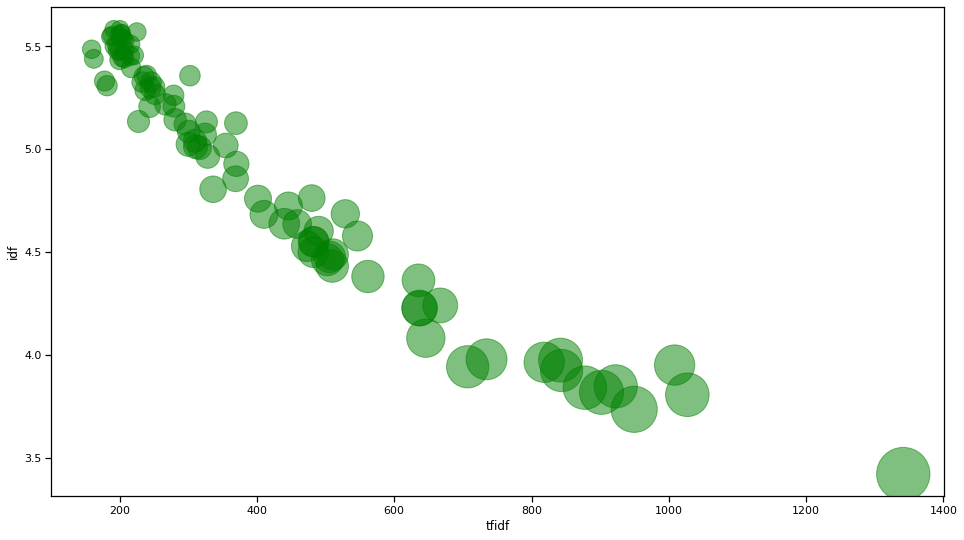

In [57]:
LFC_tfidf = TFIDF(LFC_clean)
LFC_tfidf.head(20)

Below, you find another visualization of the top 10 words by the tfidf score for the entire dataset. This will come handy for the next set of graphs which will use the 3 most frequent words from here.

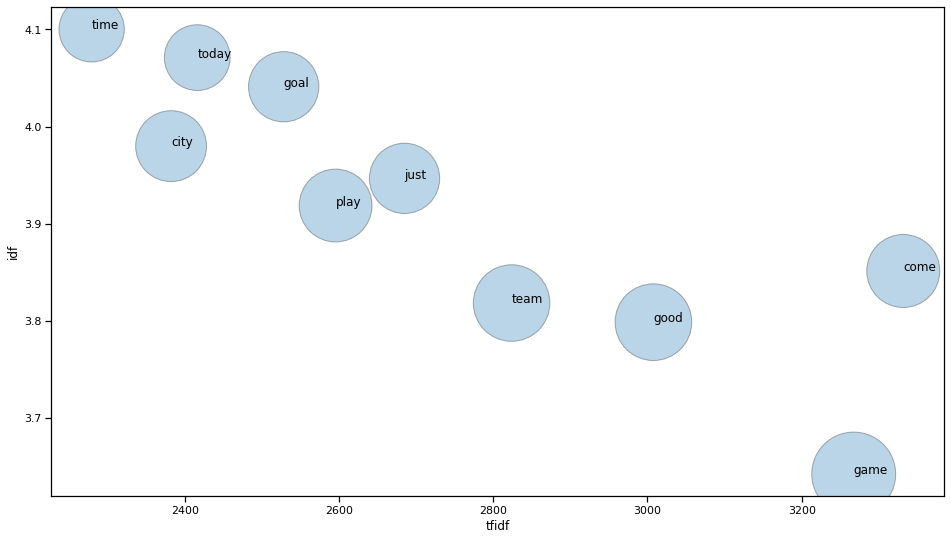

In [58]:
fig, ax = plt.subplots(figsize = (16,9))

full_tfidf.iloc[:10,:].plot.scatter(x = 'tfidf',
                        y = 'idf',
                        s = 'tf',
                        ax = ax,
                        alpha = 0.3,
                        edgecolor = 'k');

for label, x, y in zip(full_tfidf.iloc[:10,0], full_tfidf.iloc[:10,3], full_tfidf.iloc[:10,2]):
    txt = plt.annotate(label,xy=(x, y), fontsize=12)

### Word2Vec

<ipython-input-19-bc9a9bc55217>:27: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  for i in zip(models[0][word], models[1][word], models[2][word], models[3][word], models[4][word]):
<ipython-input-19-bc9a9bc55217>:29: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  models[4].wv.syn0[w2v_model.wv.vocab[word].index] = np.array(means)
<ipython-input-20-ea512a8b9f2b>:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  close_words = model.most_similar(word)
<ipython-input-20-ea512a8b9f2b>:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  wrd_vector = model[wrd_score[0]]


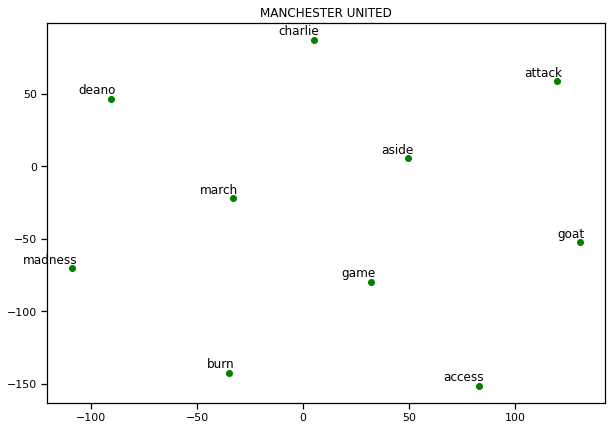

<ipython-input-19-bc9a9bc55217>:27: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  for i in zip(models[0][word], models[1][word], models[2][word], models[3][word], models[4][word]):
<ipython-input-19-bc9a9bc55217>:29: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  models[4].wv.syn0[w2v_model.wv.vocab[word].index] = np.array(means)
<ipython-input-20-ea512a8b9f2b>:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  close_words = model.most_similar(word)
<ipython-input-20-ea512a8b9f2b>:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  wrd_vector = model[wrd_score[0]]


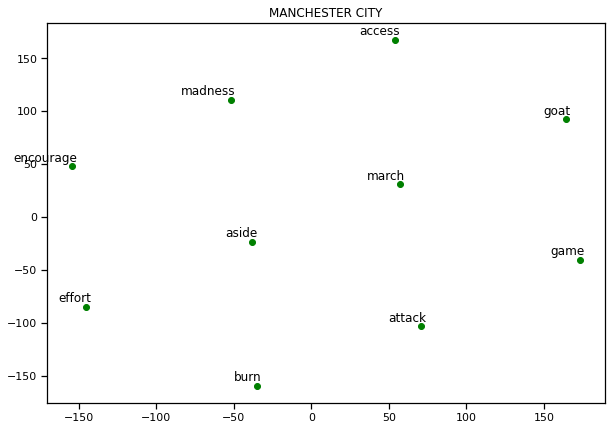

<ipython-input-19-bc9a9bc55217>:27: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  for i in zip(models[0][word], models[1][word], models[2][word], models[3][word], models[4][word]):
<ipython-input-19-bc9a9bc55217>:29: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  models[4].wv.syn0[w2v_model.wv.vocab[word].index] = np.array(means)
<ipython-input-20-ea512a8b9f2b>:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  close_words = model.most_similar(word)
<ipython-input-20-ea512a8b9f2b>:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  wrd_vector = model[wrd_score[0]]


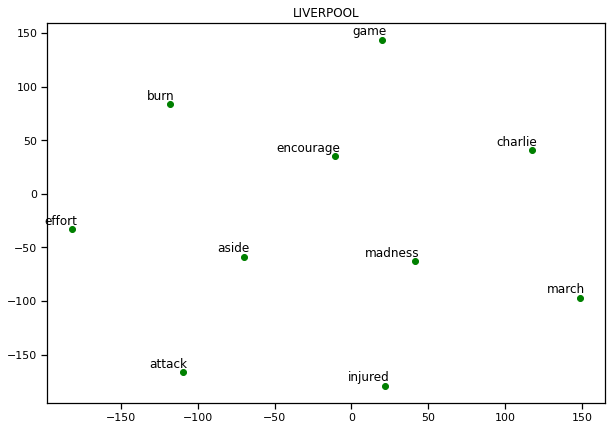

In [59]:
w2v_model = word2vec(MU_clean)
closestwords_tsnescatterplot(w2v_model, 'game','MANCHESTER UNITED')

w2v_model = word2vec(MC_clean)
closestwords_tsnescatterplot(w2v_model, 'game','MANCHESTER CITY')

w2v_model = word2vec(LFC_clean)
closestwords_tsnescatterplot(w2v_model, 'game','LIVERPOOL')

<ipython-input-19-bc9a9bc55217>:27: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  for i in zip(models[0][word], models[1][word], models[2][word], models[3][word], models[4][word]):
<ipython-input-19-bc9a9bc55217>:29: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  models[4].wv.syn0[w2v_model.wv.vocab[word].index] = np.array(means)
<ipython-input-20-ea512a8b9f2b>:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  close_words = model.most_similar(word)
<ipython-input-20-ea512a8b9f2b>:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  wrd_vector = model[wrd_score[0]]


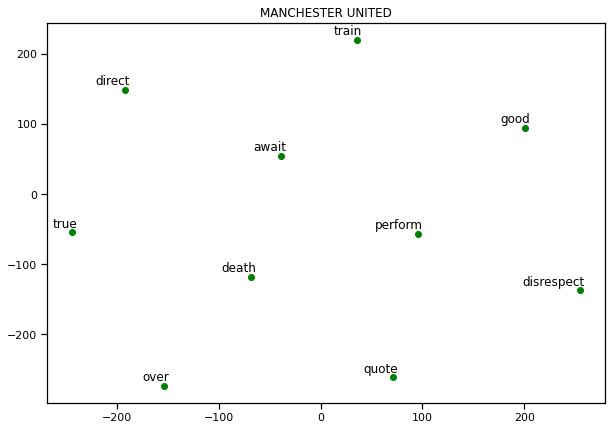

<ipython-input-19-bc9a9bc55217>:27: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  for i in zip(models[0][word], models[1][word], models[2][word], models[3][word], models[4][word]):
<ipython-input-19-bc9a9bc55217>:29: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  models[4].wv.syn0[w2v_model.wv.vocab[word].index] = np.array(means)
<ipython-input-20-ea512a8b9f2b>:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  close_words = model.most_similar(word)
<ipython-input-20-ea512a8b9f2b>:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  wrd_vector = model[wrd_score[0]]


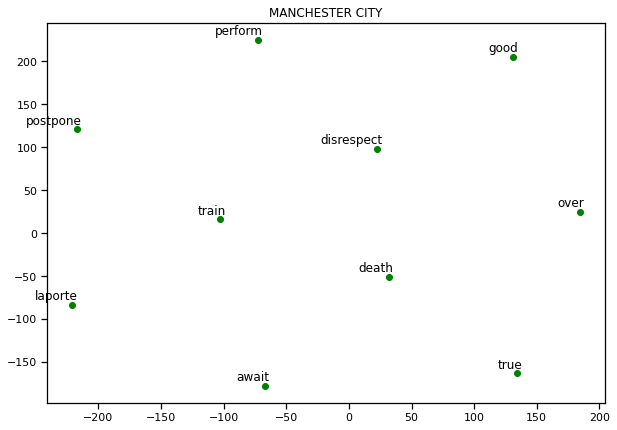

<ipython-input-19-bc9a9bc55217>:27: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  for i in zip(models[0][word], models[1][word], models[2][word], models[3][word], models[4][word]):
<ipython-input-19-bc9a9bc55217>:29: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  models[4].wv.syn0[w2v_model.wv.vocab[word].index] = np.array(means)
<ipython-input-20-ea512a8b9f2b>:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  close_words = model.most_similar(word)
<ipython-input-20-ea512a8b9f2b>:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  wrd_vector = model[wrd_score[0]]


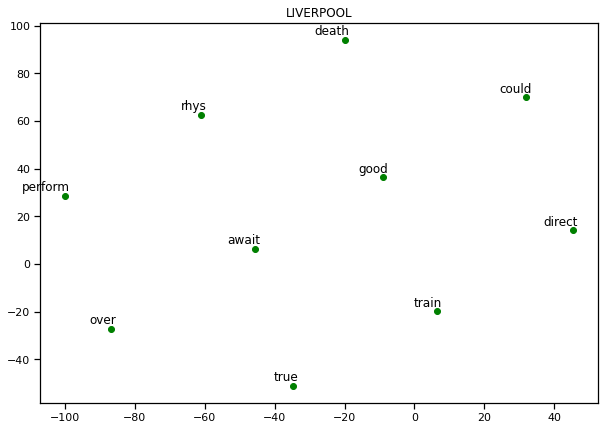

In [60]:
w2v_model = word2vec(MU_clean)
closestwords_tsnescatterplot(w2v_model, 'good','MANCHESTER UNITED')

w2v_model = word2vec(MC_clean)
closestwords_tsnescatterplot(w2v_model, 'good','MANCHESTER CITY')

w2v_model = word2vec(LFC_clean)
closestwords_tsnescatterplot(w2v_model, 'good','LIVERPOOL')

<ipython-input-19-bc9a9bc55217>:27: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  for i in zip(models[0][word], models[1][word], models[2][word], models[3][word], models[4][word]):
<ipython-input-19-bc9a9bc55217>:29: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  models[4].wv.syn0[w2v_model.wv.vocab[word].index] = np.array(means)
<ipython-input-20-ea512a8b9f2b>:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  close_words = model.most_similar(word)
<ipython-input-20-ea512a8b9f2b>:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  wrd_vector = model[wrd_score[0]]


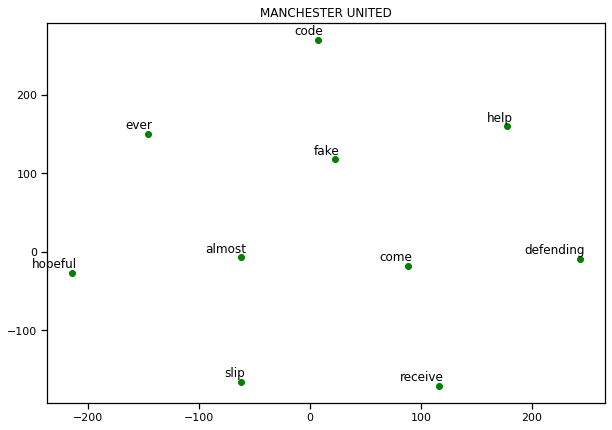

<ipython-input-19-bc9a9bc55217>:27: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  for i in zip(models[0][word], models[1][word], models[2][word], models[3][word], models[4][word]):
<ipython-input-19-bc9a9bc55217>:29: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  models[4].wv.syn0[w2v_model.wv.vocab[word].index] = np.array(means)
<ipython-input-20-ea512a8b9f2b>:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  close_words = model.most_similar(word)
<ipython-input-20-ea512a8b9f2b>:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  wrd_vector = model[wrd_score[0]]


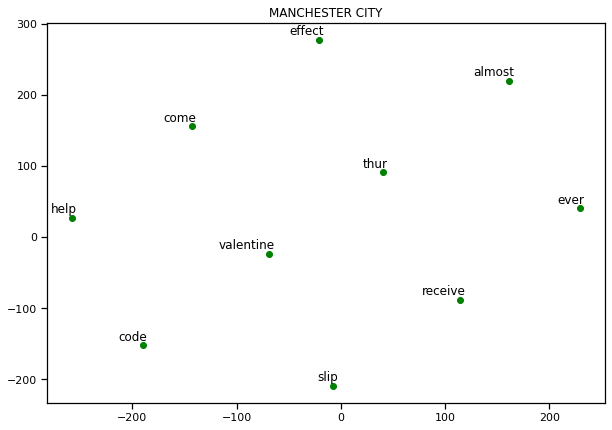

<ipython-input-19-bc9a9bc55217>:27: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  for i in zip(models[0][word], models[1][word], models[2][word], models[3][word], models[4][word]):
<ipython-input-19-bc9a9bc55217>:29: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  models[4].wv.syn0[w2v_model.wv.vocab[word].index] = np.array(means)
<ipython-input-20-ea512a8b9f2b>:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  close_words = model.most_similar(word)
<ipython-input-20-ea512a8b9f2b>:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  wrd_vector = model[wrd_score[0]]


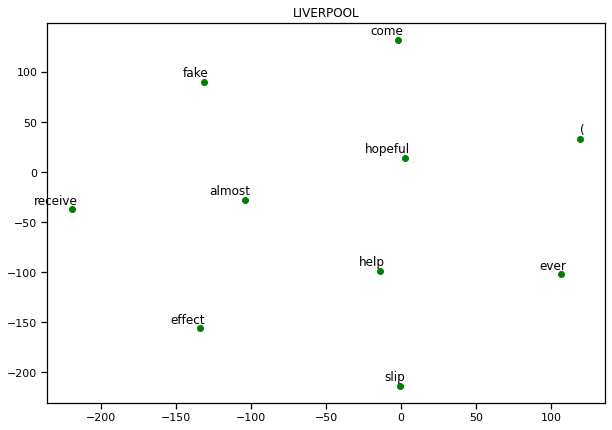

In [61]:
w2v_model = word2vec(MU_clean)
closestwords_tsnescatterplot(w2v_model, 'come','MANCHESTER UNITED')

w2v_model = word2vec(MC_clean)
closestwords_tsnescatterplot(w2v_model, 'come','MANCHESTER CITY')

w2v_model = word2vec(LFC_clean)
closestwords_tsnescatterplot(w2v_model, 'come','LIVERPOOL')

In the above scatterplots, we can notice that the results that we get from the Word2Vec model if we use any of the three single datasets are quite different from the ones of the entire corpus. Obviously, in this case we get more redundant results as we are considering a smaller dataset which gives some not real similarities.

## Thanks for the opportunity and I hope you liked the work! 